In [1]:
import os
import cv2
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageEnhance
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow.keras.models import load_model

c:\Users\erand\.conda\envs\gpu_env\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
class CustomScaleLayer(tf.keras.layers.Layer):
    def __init__(self, scale=1.0, **kwargs):
        self.scale = kwargs.pop("scale", scale)
        super().__init__(**kwargs)

    def call(self, inputs):
        if isinstance(inputs, (list, tuple)):
            # If inputs is a list/tuple of tensors, scale each one
            return [x * self.scale for x in inputs]
        # If input is a single tensor
        return inputs * self.scale

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config

In [3]:
MODEL_PATH = "chromosome_classifier_final.h5"
IMAGE_SIZE = 224
NUM_CLASSES = 24

if os.path.exists(MODEL_PATH):
    test_model = load_model(
        MODEL_PATH,
        custom_objects={"CustomScaleLayer": CustomScaleLayer}
    )
    print(f"✅ Loaded trained classifier from {MODEL_PATH}")
else:
    test_model = None
    print("❌ No trained model found. Please train the model first.")

✅ Loaded trained classifier from chromosome_classifier_final.h5


In [4]:
def setup_sam_model():
    try:
        from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
        sam_checkpoint = "sam_vit_h_4b8939.pth"

        if not os.path.exists(sam_checkpoint):
            print("⚠️ SAM checkpoint not found.")
            print("Download from: https://github.com/facebookresearch/segment-anything#model-checkpoints")
            return None, None

        model_type = "vit_h"
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")

        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        sam.to(device=device)

        mask_generator = SamAutomaticMaskGenerator(
            model=sam,
            points_per_side=32,
            pred_iou_thresh=0.88,
            stability_score_thresh=0.92,
            crop_n_layers=1,
            crop_n_points_downscale_factor=2,
            min_mask_region_area=600
        )
        return sam, mask_generator

    except ImportError:
        print("❌ segment-anything not installed. Run: pip install segment-anything")
        return None, None
    
# -----------------------------
# 5. Image enhancement & mask filtering
# -----------------------------
def enhance_image(image_rgb):
    pil_img = Image.fromarray(image_rgb)
    enhanced = ImageEnhance.Contrast(pil_img).enhance(1.2)
    enhanced = ImageEnhance.Sharpness(enhanced).enhance(1.1)
    return np.array(enhanced)

def filter_chromosome_masks(masks):
    filtered = []
    for mask in masks:
        area = mask['area']
        x, y, w, h = mask['bbox']
        aspect_ratio = max(w/h, h/w) if min(w,h) > 0 else 0
        extent = area / (w*h) if w*h > 0 else 0
        if (800 <= area <= 35000 and 1.5 <= aspect_ratio <= 10 and extent >= 0.3):
            filtered.append(mask)
    return filtered

def remove_duplicate_masks(masks, eps=50):
    if len(masks) <= 24: return masks
    centers = [[m['bbox'][0] + m['bbox'][2]/2, m['bbox'][1] + m['bbox'][3]/2] for m in masks]
    clustering = DBSCAN(eps=eps, min_samples=1).fit(centers)
    unique = []
    for cluster_id in np.unique(clustering.labels_):
        cluster = np.where(clustering.labels_ == cluster_id)[0]
        best = max(cluster, key=lambda i: masks[i]['stability_score'])
        unique.append(masks[best])
    return unique

# -----------------------------
# 6. Segmentation + Classification
# -----------------------------
def segment_chromosomes(image_path, mask_generator, output_dir="test_chromosomes"):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"❌ Could not read {image_path}")
        return [], []

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    enhanced = enhance_image(image_rgb)

    print("🔹 Generating SAM masks...")
    masks = mask_generator.generate(enhanced)
    masks = filter_chromosome_masks(masks)
    masks = remove_duplicate_masks(masks)
    print(f"✅ Final chromosomes detected: {len(masks)}")

    os.makedirs(output_dir, exist_ok=True)
    crops, info = [], []

    for i, mask in enumerate(masks):
        x, y, w, h = mask['bbox']
        pad = max(5, int(0.1 * min(w,h)))
        crop = image_rgb[max(0,y-pad):y+h+pad, max(0,x-pad):x+w+pad]
        pil_crop = Image.fromarray(crop)
        crop_enh = ImageEnhance.Contrast(pil_crop).enhance(1.3)
        crop_enh = ImageEnhance.Sharpness(crop_enh).enhance(1.2)
        crop_arr = np.array(ImageEnhance.Brightness(crop_enh).enhance(0.9))
        crop_resized = cv2.resize(crop_arr, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
        crops.append(crop_resized)
        fname = f"chr_{i:03d}.jpg"
        cv2.imwrite(os.path.join(output_dir,fname), cv2.cvtColor(crop_arr,cv2.COLOR_RGB2BGR))
        info.append({"filename": fname, "enhanced_crop": crop_arr, "bbox": mask['bbox'], "area": mask['area']})

    return np.array(crops), info

def get_chromosome_name(cid):
    return f"Chr {cid+1}" if cid <= 21 else ("Chr X" if cid==22 else "Chr Y")

def visualize_classification_results(crops_info, classes, confs):
    cols = 4
    rows = math.ceil(len(crops_info)/cols)
    plt.figure(figsize=(16, rows*4))
    for i, info in enumerate(crops_info):
        plt.subplot(rows, cols, i+1)
        plt.imshow(info['enhanced_crop'])
        cname = get_chromosome_name(classes[i])
        conf = confs[i]
        color = 'green' if conf>0.9 else 'orange' if conf>0.7 else 'red'
        plt.title(f"{cname}\nConf: {conf:.2f}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def analyze_karyotype(model, image_path, mask_generator):
    crops, info = segment_chromosomes(image_path, mask_generator)
    if len(crops)==0:
        print("❌ No chromosomes detected")
        return
    preds = model.predict(crops, batch_size=32)
    classes = np.argmax(preds, axis=1)
    confs = np.max(preds, axis=1)

    print("\n=== Classification Results ===")
    for fname,cid,c in zip([i['filename'] for i in info], classes, confs):
        print(f"{fname}: {get_chromosome_name(cid)} (conf={c:.3f})")

    visualize_classification_results(info, classes, confs)
    return crops, classes, confs

Using device: cuda


c:\Users\erand\.conda\envs\gpu_env\lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


🔹 Generating SAM masks...
✅ Final chromosomes detected: 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

=== Classification Results ===
chr_000.jpg: Chr 9 (conf=0.523)
chr_001.jpg: Chr 9 (conf=0.523)
chr_002.jpg: Chr 9 (conf=0.523)
chr_003.jpg: Chr 9 (conf=0.523)
chr_004.jpg: Chr 9 (conf=0.523)
chr_005.jpg: Chr 9 (conf=0.523)
chr_006.jpg: Chr 9 (conf=0.523)
chr_007.jpg: Chr 9 (conf=0.523)
chr_008.jpg: Chr 9 (conf=0.523)
chr_009.jpg: Chr 9 (conf=0.523)
chr_010.jpg: Chr 9 (conf=0.523)
chr_011.jpg: Chr 9 (conf=0.523)
chr_012.jpg: Chr 9 (conf=0.523)
chr_013.jpg: Chr 9 (conf=0.523)
chr_014.jpg: Chr 9 (conf=0.523)
chr_015.jpg: Chr 9 (conf=0.523)
chr_016.jpg: Chr 9 (conf=0.523)
chr_017.jpg: Chr 9 (conf=0.523)


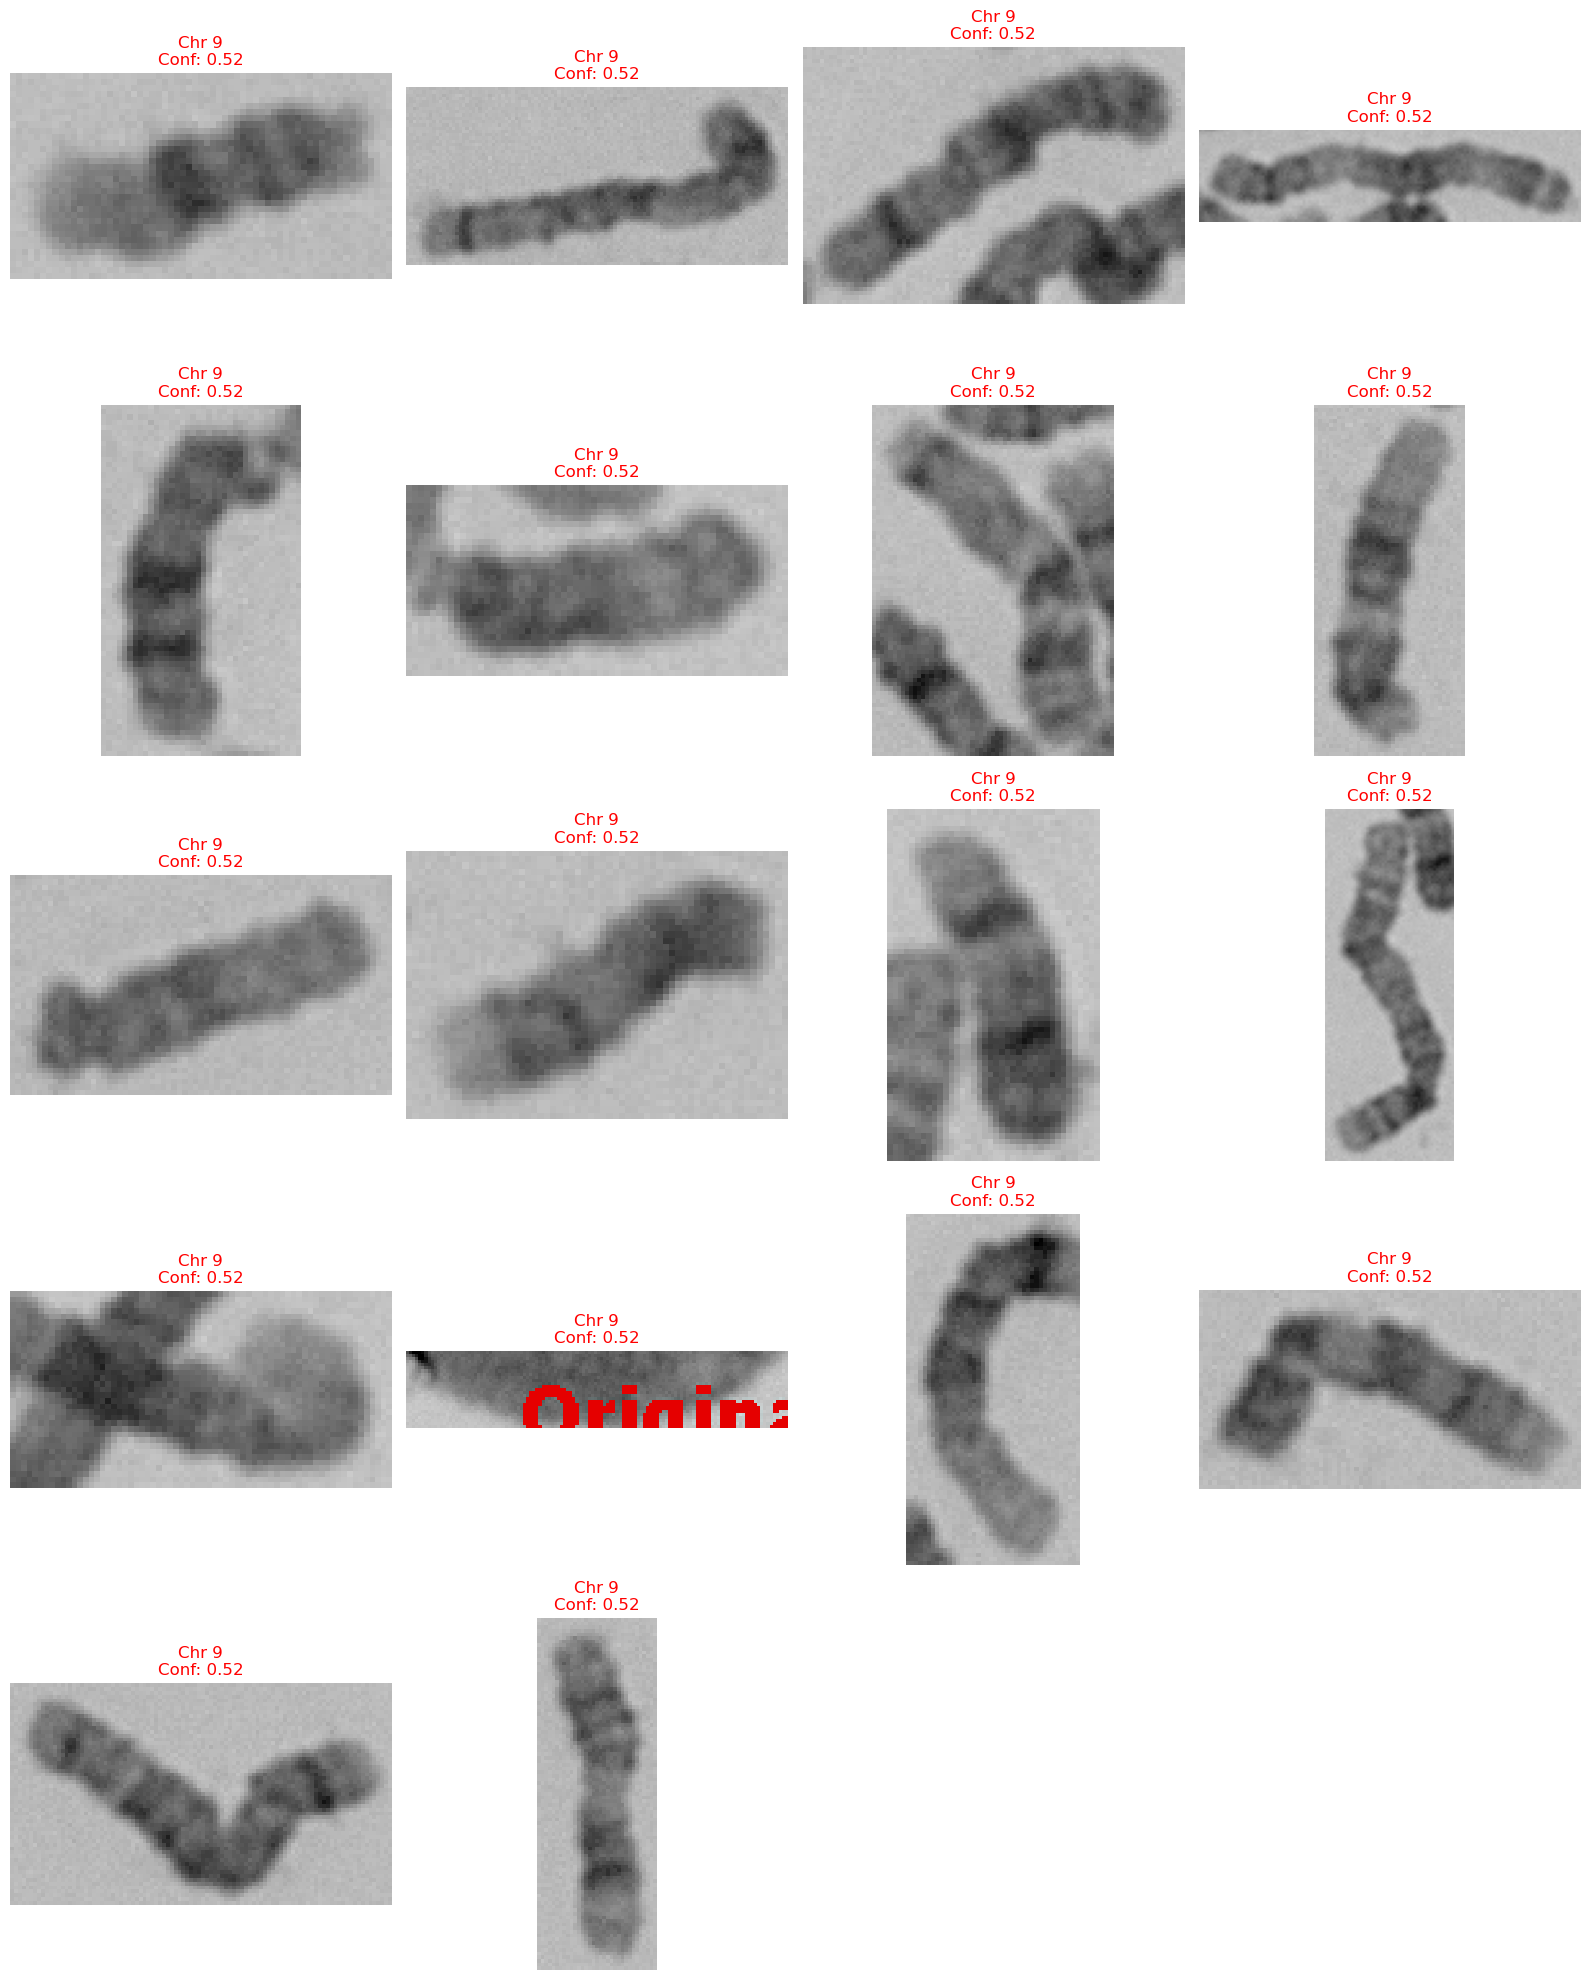

In [5]:
sam_model, mask_gen = setup_sam_model()
test_img = "original.tif"  # <-- Replace with your uploaded test image path

if test_model is not None and mask_gen is not None:
    analyze_karyotype(test_model, test_img, mask_gen)